Add Starting Pitching to Model

    In the last notebook we augmented our dataframe to include various features based on the starting pitcher's performance
    Now we will add these features in to see how much improvement we get to our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df = pd.read_csv('df_bp5.csv', low_memory=False)

BEGIN MODELING

In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1970) & (df.season<=2015)]
df_valid = df[(df.season>=2016) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [4]:
hv_mean = df_train.home_victory.mean()

FIRST -- Just add in ERA and WHIP over last 35 games (in addition to first model params)

In [5]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v', 
]
target = 'home_victory'

In [6]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [7]:
X_train.shape, X_valid.shape, X_test.shape

((98593, 8), (10611, 8), (4852, 8))

In [8]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689578
[20]	valid_0's binary_logloss: 0.688533
[30]	valid_0's binary_logloss: 0.68772
[40]	valid_0's binary_logloss: 0.687031
[50]	valid_0's binary_logloss: 0.686367
[60]	valid_0's binary_logloss: 0.685786
[70]	valid_0's binary_logloss: 0.685306
[80]	valid_0's binary_logloss: 0.684874
[90]	valid_0's binary_logloss: 0.684521
[100]	valid_0's binary_logloss: 0.684129
[110]	valid_0's binary_logloss: 0.683738
[120]	valid_0's binary_logloss: 0.683396
[130]	valid_0's binary_logloss: 0.683084
[140]	valid_0's binary_logloss: 0.682849
[150]	valid_0's binary_logloss: 0.682609
[160]	valid_0's binary_logloss: 0.68241
[170]	valid_0's binary_logloss: 0.682217
[180]	valid_0's binary_logloss: 0.682026
[190]	valid_0's binary_logloss: 0.681891
[200]	valid_0's binary_logloss: 0.681698
[210]	valid_0's binary_logloss: 0.681589
[220]	valid_0's binary_logloss: 0.681481
[230]	valid_0's binary_logloss: 0.681416
[240]	v

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [9]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [10]:
# previous model gave 0.6837740579507787
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.674671598965824, 0.6904958727145366)

In [11]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6675629431340582

It would behoove us to be define a way to quantify to relate our models both to the Las Vegas oddsmakers model and if we were to "naively" select the home team 53.8% of the time because that's what seems to happen.

As a reminder, our models include:

    - Simple (first): OBP & SLG
    - Current: OBP, SLG, + Starting Pitcher ERA and WHIP over their past 35 starts

We will define a 'basis point' (bp) to be log_loss = 0.0001

This will allow us to relate the models to each other and using more familiar integer values

In [12]:
# naive-LV, naive-simp_mod, naive-current_mod

np.round([0.6905 - 0.6676, 0.6905 - 0.6837, 0.6905 - 0.6747], decimals=4)

array([0.0229, 0.0068, 0.0158])

In [13]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

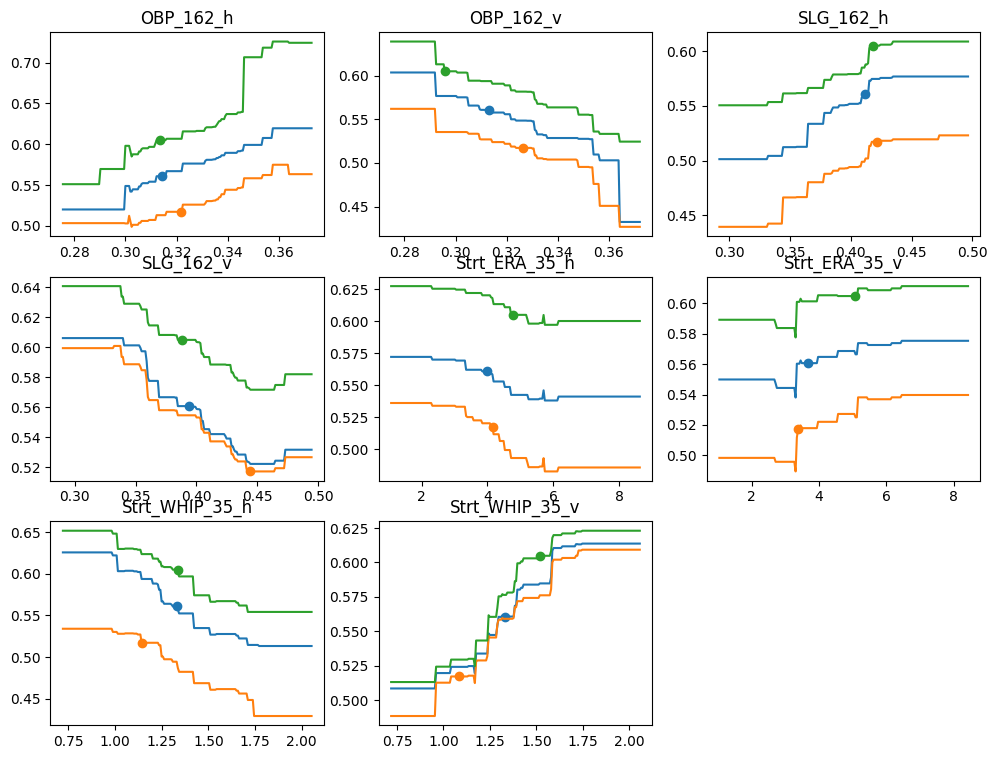

In [14]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

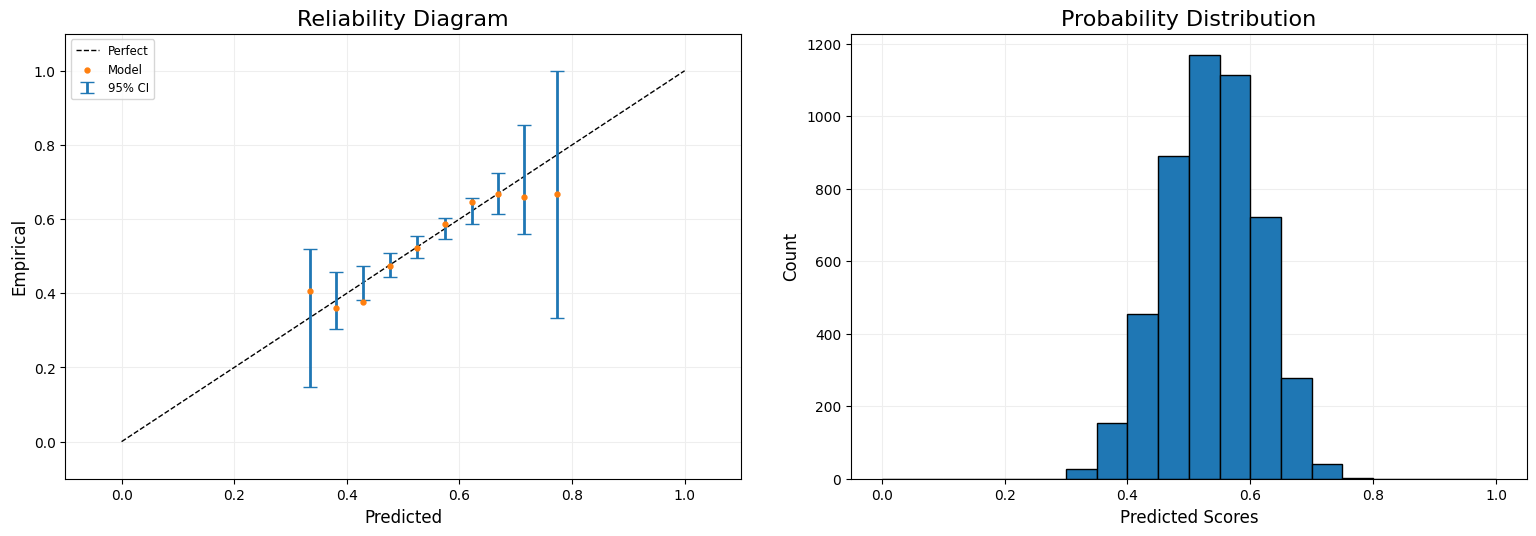

In [15]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [20]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [17]:
# This shows for each game, how the different features affected 

sv_lgbm.head(5).round(3)

,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,Strt_ERA_35_h,Strt_ERA_35_v,Strt_WHIP_35_h,Strt_WHIP_35_v,Intercept
0,-0.066,0.072,0.112,0.016,0.041,0.015,0.186,0.073,0.159
1,-0.071,0.039,0.082,0.017,0.024,-0.077,0.107,-0.176,0.159
2,-0.024,0.009,0.090,-0.078,-0.066,-0.083,0.058,-0.200,0.159
3,-0.218,0.025,-0.029,-0.063,0.021,-0.078,0.042,-0.173,0.159
4,-0.048,0.015,0.061,-0.105,0.030,0.003,0.131,-0.262,0.159


In [23]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept         0.158593
Strt_WHIP_35_h    0.100027
Strt_WHIP_35_v    0.092721
OBP_162_h         0.077053
OBP_162_v         0.068061
SLG_162_h         0.054741
SLG_162_v         0.051684
Strt_ERA_35_h     0.039934
Strt_ERA_35_v     0.035863
dtype: float64

Let's add in a few more pitching features...

In [24]:
# Add in SO% and "Modified Slugging Against"

features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
]
target = 'home_victory'

In [25]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [26]:
X_train.shape, X_valid.shape, X_test.shape

((98593, 14), (10611, 14), (4852, 14))

In [27]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689561
[20]	valid_0's binary_logloss: 0.688495
[30]	valid_0's binary_logloss: 0.687661
[40]	valid_0's binary_logloss: 0.686954
[50]	valid_0's binary_logloss: 0.686272
[60]	valid_0's binary_logloss: 0.685663
[70]	valid_0's binary_logloss: 0.685134
[80]	valid_0's binary_logloss: 0.684599
[90]	valid_0's binary_logloss: 0.684116
[100]	valid_0's binary_logloss: 0.683723
[110]	valid_0's binary_logloss: 0.683358
[120]	valid_0's binary_logloss: 0.682981
[130]	valid_0's binary_logloss: 0.682619
[140]	valid_0's binary_logloss: 0.682286
[150]	valid_0's binary_logloss: 0.682054
[160]	valid_0's binary_logloss: 0.681807
[170]	valid_0's binary_logloss: 0.681602
[180]	valid_0's binary_logloss: 0.6814
[190]	valid_0's binary_logloss: 0.681199
[200]	valid_0's binary_logloss: 0.68102
[210]	valid_0's binary_logloss: 0.680856
[220]	valid_0's binary_logloss: 0.680694
[230]	valid_0's binary_logloss: 0.680548
[240]	va

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [28]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [29]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6745573822650283, 0.6904958727145366)

Note that adding those two features improved the model by a mere 1 bp

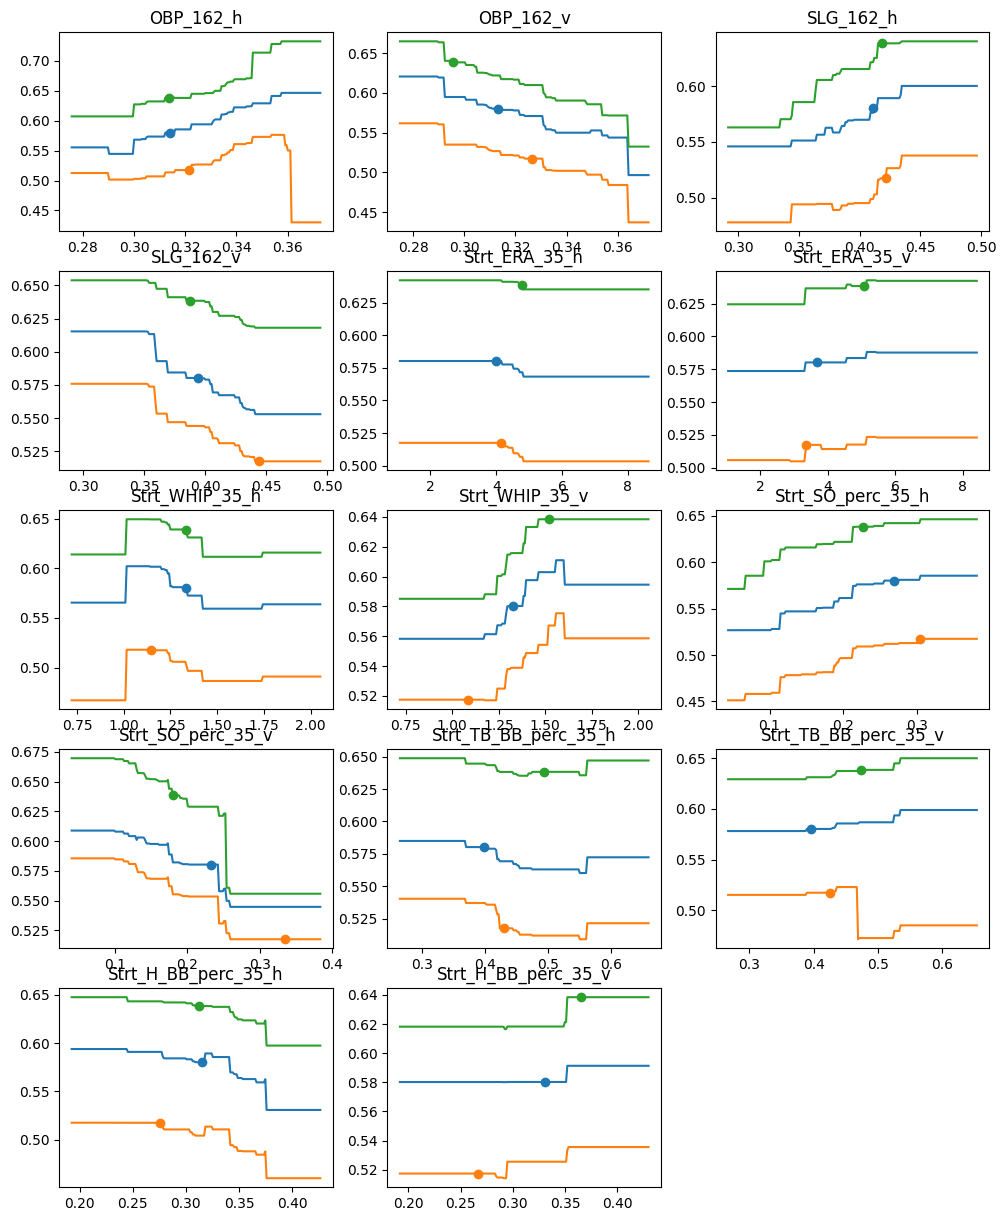

In [31]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

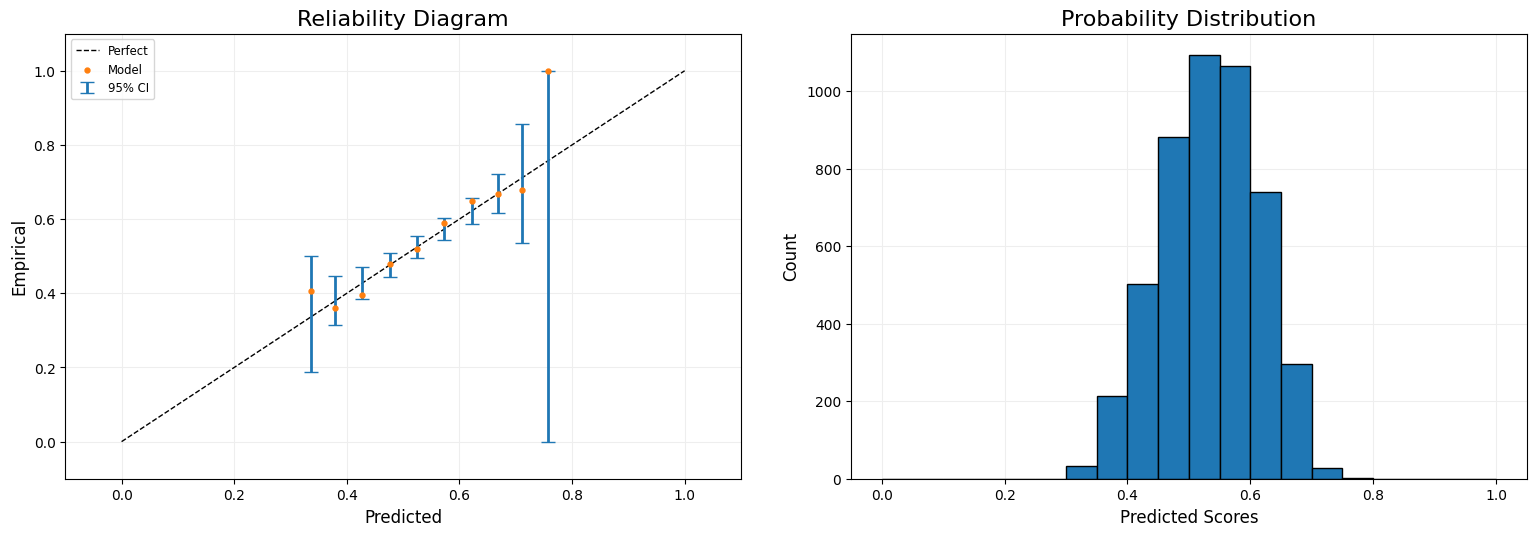

In [32]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [33]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [34]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.158641
Strt_SO_perc_35_v       0.103168
Strt_SO_perc_35_h       0.082766
OBP_162_h               0.071854
OBP_162_v               0.066714
Strt_WHIP_35_v          0.056868
Strt_WHIP_35_h          0.056508
SLG_162_h               0.050147
SLG_162_v               0.041522
Strt_H_BB_perc_35_h     0.034639
Strt_TB_BB_perc_35_h    0.028700
Strt_ERA_35_v           0.023600
Strt_H_BB_perc_35_v     0.019639
Strt_TB_BB_perc_35_v    0.015475
Strt_ERA_35_h           0.012068
dtype: float64

In [35]:
## Let's add in the 10 game lookback features
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_ERA_10_h','Strt_ERA_10_v',
            'Strt_WHIP_10_h','Strt_WHIP_10_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Strt_TB_BB_perc_10_h', 'Strt_TB_BB_perc_10_v',
]
target = 'home_victory'

In [36]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [37]:
X_train.shape, X_valid.shape, X_test.shape

((98593, 20), (10611, 20), (4852, 20))

In [38]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689578
[20]	valid_0's binary_logloss: 0.688514
[30]	valid_0's binary_logloss: 0.687687
[40]	valid_0's binary_logloss: 0.687
[50]	valid_0's binary_logloss: 0.686387
[60]	valid_0's binary_logloss: 0.685876
[70]	valid_0's binary_logloss: 0.685403
[80]	valid_0's binary_logloss: 0.684864
[90]	valid_0's binary_logloss: 0.684526
[100]	valid_0's binary_logloss: 0.684144
[110]	valid_0's binary_logloss: 0.683806
[120]	valid_0's binary_logloss: 0.683425
[130]	valid_0's binary_logloss: 0.683144
[140]	valid_0's binary_logloss: 0.682904
[150]	valid_0's binary_logloss: 0.682623
[160]	valid_0's binary_logloss: 0.6824
[170]	valid_0's binary_logloss: 0.682206
[180]	valid_0's binary_logloss: 0.681964
[190]	valid_0's binary_logloss: 0.681779
[200]	valid_0's binary_logloss: 0.681547
[210]	valid_0's binary_logloss: 0.681341
[220]	valid_0's binary_logloss: 0.681195
[230]	valid_0's binary_logloss: 0.681038
[240]	vali

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [39]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [40]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6747461655292659, 0.6904958727145366)

In [41]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

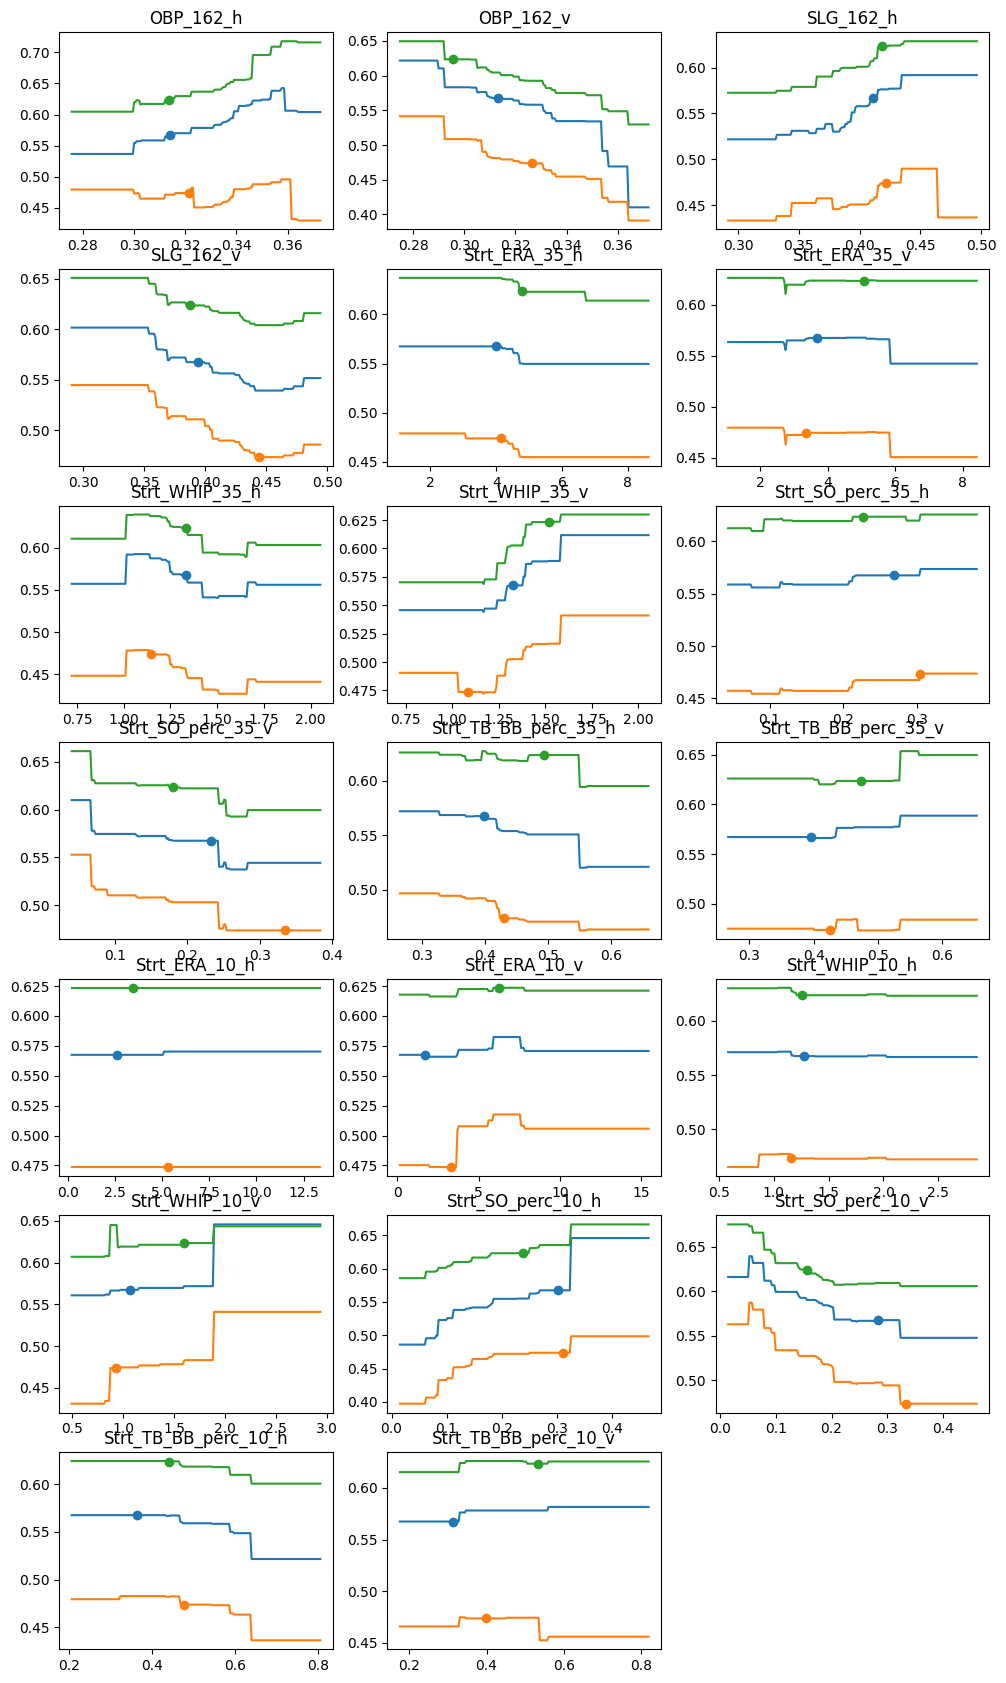

In [42]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

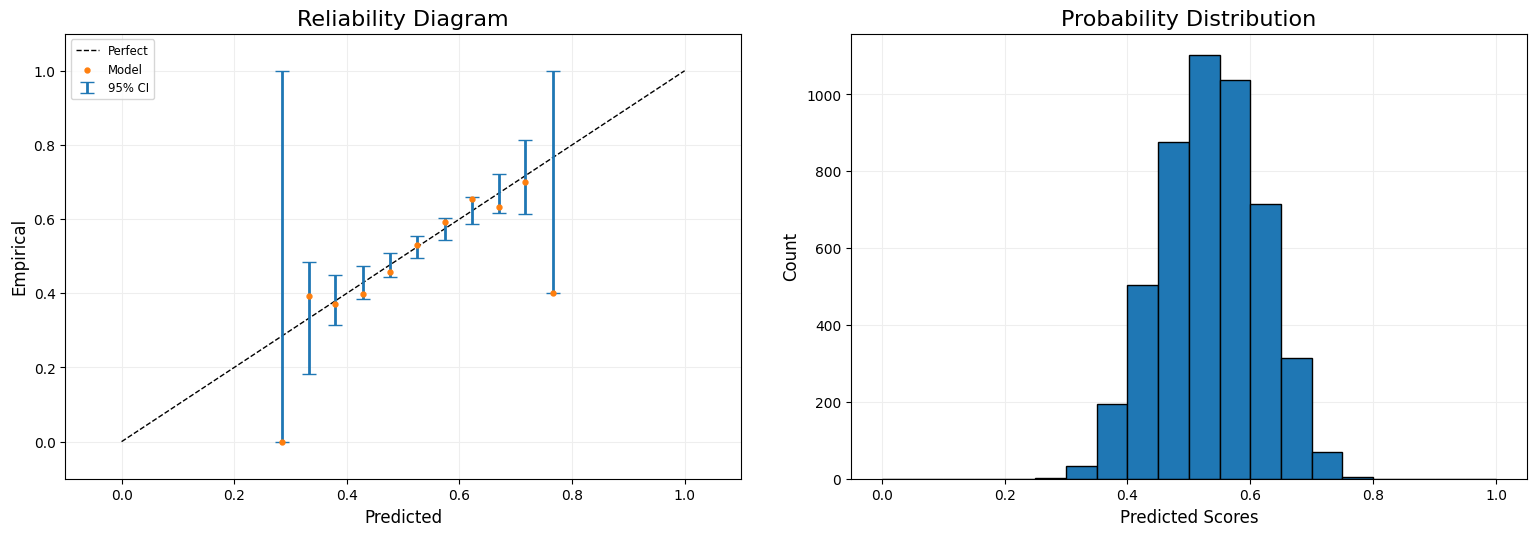

In [43]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [44]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [45]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.158905
Strt_SO_perc_10_h       0.081696
Strt_WHIP_35_h          0.073714
Strt_SO_perc_10_v       0.073455
OBP_162_h               0.068958
OBP_162_v               0.068617
Strt_WHIP_35_v          0.067148
SLG_162_h               0.055299
SLG_162_v               0.042365
Strt_SO_perc_35_v       0.031174
Strt_TB_BB_perc_35_h    0.023301
Strt_ERA_35_h           0.020935
Strt_ERA_10_v           0.019963
Strt_SO_perc_35_h       0.017845
Strt_ERA_35_v           0.015753
Strt_TB_BB_perc_10_h    0.014844
Strt_TB_BB_perc_35_v    0.012444
Strt_WHIP_10_v          0.008564
Strt_WHIP_10_h          0.007617
Strt_TB_BB_perc_10_v    0.006848
Strt_ERA_10_h           0.002256
dtype: float64

In [46]:
# Choose the best window size for each metric, drop ERA

features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            
]
target = 'home_victory'

In [47]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [48]:
X_train.shape, X_valid.shape, X_test.shape

((98593, 10), (10611, 10), (4852, 10))

In [49]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689554
[20]	valid_0's binary_logloss: 0.688544
[30]	valid_0's binary_logloss: 0.68769
[40]	valid_0's binary_logloss: 0.687005
[50]	valid_0's binary_logloss: 0.686407
[60]	valid_0's binary_logloss: 0.685809
[70]	valid_0's binary_logloss: 0.685368
[80]	valid_0's binary_logloss: 0.684851
[90]	valid_0's binary_logloss: 0.684488
[100]	valid_0's binary_logloss: 0.684076
[110]	valid_0's binary_logloss: 0.683755
[120]	valid_0's binary_logloss: 0.683511
[130]	valid_0's binary_logloss: 0.683223
[140]	valid_0's binary_logloss: 0.682928
[150]	valid_0's binary_logloss: 0.682656
[160]	valid_0's binary_logloss: 0.682465
[170]	valid_0's binary_logloss: 0.682223
[180]	valid_0's binary_logloss: 0.682032
[190]	valid_0's binary_logloss: 0.681874
[200]	valid_0's binary_logloss: 0.681697
[210]	valid_0's binary_logloss: 0.681558
[220]	valid_0's binary_logloss: 0.681377
[230]	valid_0's binary_logloss: 0.681256
[240]	

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [50]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [51]:
# now about 5 bps worse than previous model...

log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6751613263147193, 0.6904958727145366)

In [52]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6675629431340582

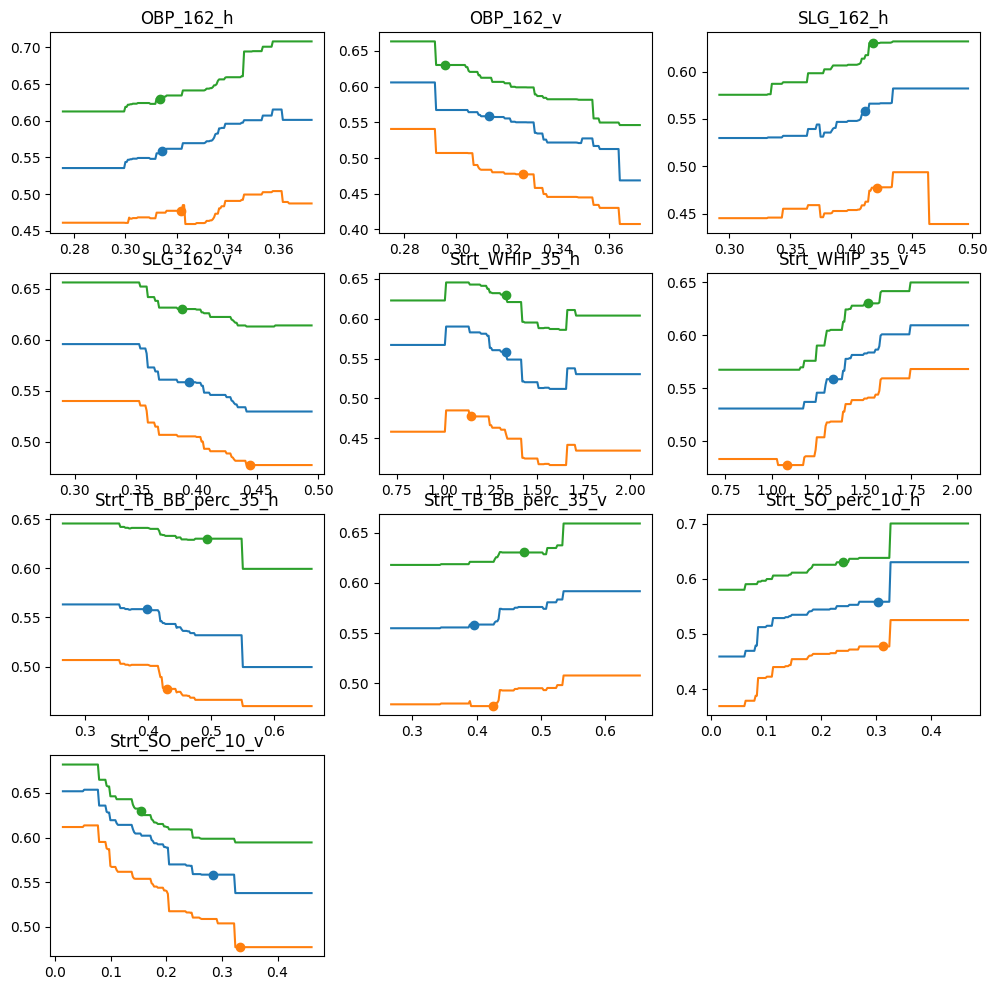

In [53]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

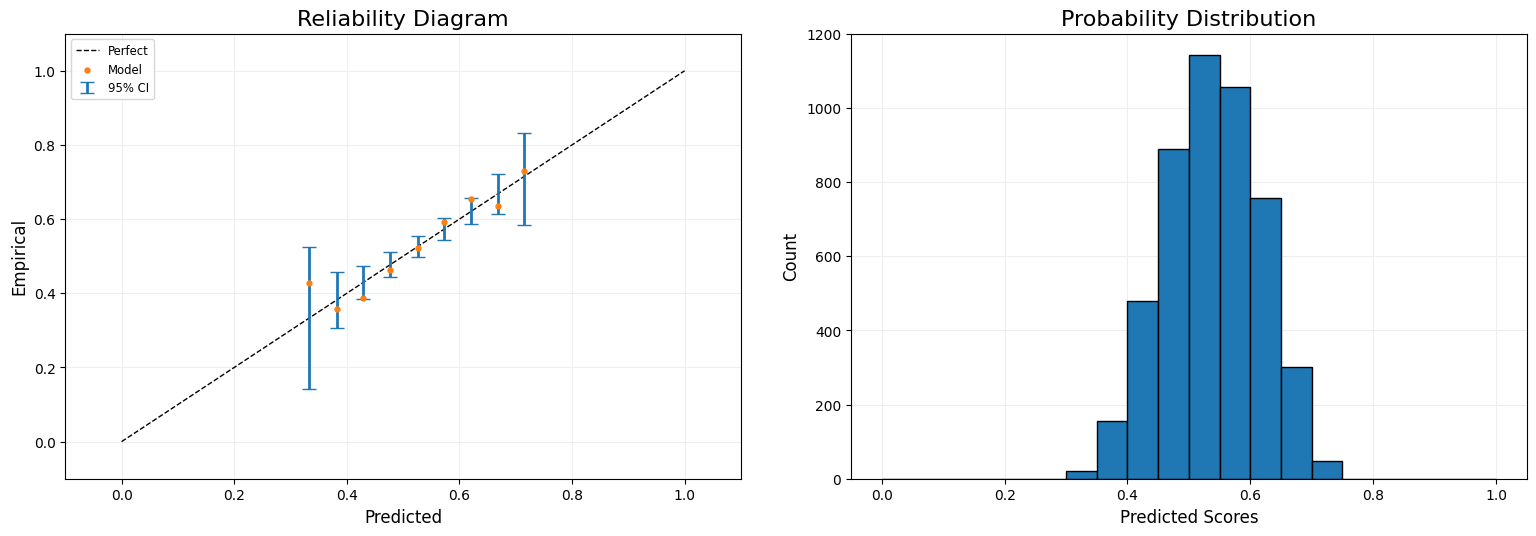

In [54]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [55]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [56]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.158739
Strt_SO_perc_10_v       0.099595
Strt_SO_perc_10_h       0.090332
Strt_WHIP_35_h          0.086526
Strt_WHIP_35_v          0.082738
OBP_162_h               0.068717
OBP_162_v               0.068423
SLG_162_h               0.053095
SLG_162_v               0.040255
Strt_TB_BB_perc_35_h    0.034406
Strt_TB_BB_perc_35_v    0.030276
dtype: float64

How much do these differences in log loss really mean?

When model A does a few bps better than model B in log loss, how should we think about that?

Is it a meaningful improvement?
How do we know it is not just "luck of the draw" of the test set
We'll run some quick simulations to build our intuition about this.

In [57]:
# Simulate a test set (with given "true" probabilities) and compare two models, 

def ll_dist(probvec_true, probvec_mod1, probvec_mod2, num_trials):
    llvec_mod1 = np.zeros(num_trials)
    llvec_mod2 = np.zeros(num_trials)
    for i in range(num_trials):
        sim_outcome = np.random.binomial(n=1, p=probvec_true)
        llvec_mod1[i] = log_loss(sim_outcome, probvec_mod1)
        llvec_mod2[i] = log_loss(sim_outcome, probvec_mod2)
    return(llvec_mod1 - llvec_mod2)

In [58]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)

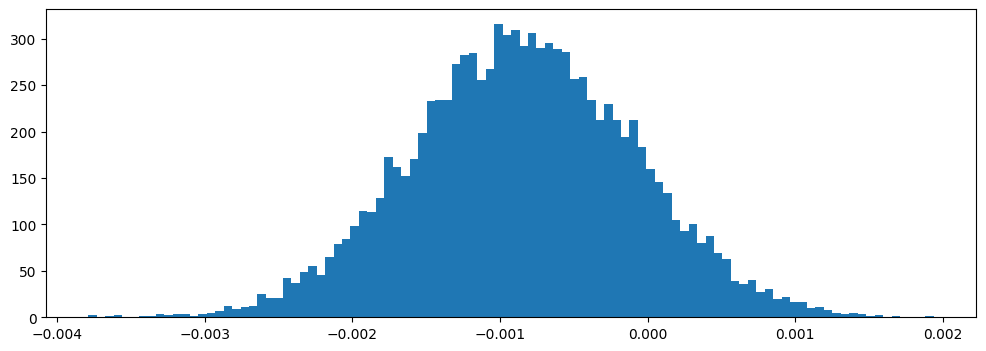

In [59]:
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

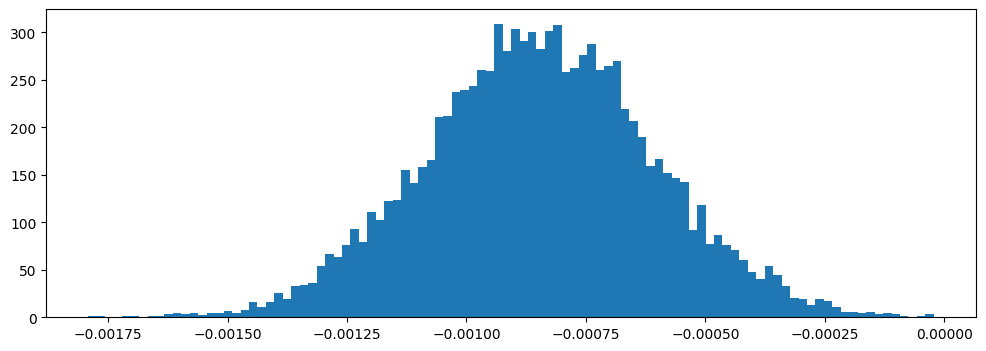

In [60]:
pv_true = np.repeat(df_test.implied_prob_h_mid,10)
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

In [61]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.10, .10, len(pv_true))

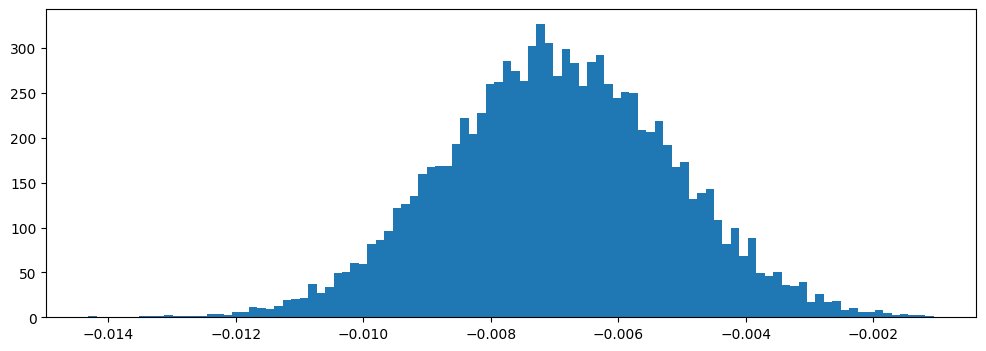

In [62]:

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

Conclusions

    - Could be that 5-10 bps improvement is meaningful!
    - Variation due to test set size is considerable
    - Not a simple matter to increase test set size in this problem
    - For now, still need to improve beyond minor optimizations


Potential Next Steps??

    - Have nothing about the quality of the bullpen
    - Bullpen is more meaningful in recent years, as starting pitchers work fewer innings
    - Could cause an issue with "model drift" (something to explore later on)
    - We don't account for the specific hitting lineup (would need individual batter data)
    - We have nothing about fielding
    - Several additional sources of model drift
    - Rule changes about infield positioning
    - Pitching clock
    - NL now has a DH